#  Model Notebook
Для повышения модульности проект разбит на 2 блокнота - для сбора данных в датасет и собственно модель для работы с датасетом.  
В этой версии  блокнота методом кроссвалидации  оцениваются 2 модели - LGBM и RandomForest с различными гипер параметрами. Для разбора и отрисовки  результата кроссвалидации используется отдельный классю  
В конце блокнота производится финальное тестирование и оценивается влияние наиболее значимых признаков

In [1]:
import numpy as np
import re
import pandas as pd
import glob
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS as tabcols

from sklearn.linear_model  import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,accuracy_score,recall_score,precision_score,f1_score
import lightgbm as lgb

In [2]:
rnd = 499
np.random.seed(rnd)


### Загрузка данных

Собранный датасет  экспортируются как full outer join, что бы можно было оценить его качество и количество промахов.   
Но здесь незаполненнные поля исправить неоткуда, поэтому я просто удаляю ошибки подготовки   
Также удаляю колонки, не нужные в моделировании (в этой версии только названия фильмов)

In [3]:
df = pd.read_csv('datasets/movies.csv')
df.info()
label_cols = ['movie']
target_col = 'level'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Columns: 111 entries, Unnamed: 0 to level
dtypes: float64(108), int64(1), object(2)
memory usage: 251.6+ KB


In [4]:
df = df[~df.isna().any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 265
Columns: 111 entries, Unnamed: 0 to level
dtypes: float64(108), int64(1), object(2)
memory usage: 189.9+ KB


### Очистка данных

В этой версии проекта реализована "фабрика признаков" позволяющая форимровать  до 100 различных признаков из файла субтитров.   
Естественно, не все они одинаково полезны , а  при таком механическом создании многие будут коррелировать между собой. Пока нет алгоритма автоматического сокращения признаков, так что я вручную убираю те, у которых есть пара с корреляцией больше 0.90

In [5]:
# this function picks top features pairs from correlation matrix of the dataframe 
def top_corr(num_rows = 10,ascending =False):
    x = [ c for c in df.columns if c not in ['movie','level'] ]
    df_corr =pd.melt( df[x].corr(),ignore_index=False).sort_values(by='value',ascending=ascending)
    print( df_corr[df_corr.index!=df_corr.variable].head(num_rows) )
    
top_corr(20)   

                      variable     value
B2_wrd_ps_mean  B2_cnt_ps_mean  0.999203
B2_cnt_ps_mean  B2_wrd_ps_mean  0.999203
C1_cnt_ps_mean  C1_wrd_ps_mean  0.998991
C1_wrd_ps_mean  C1_cnt_ps_mean  0.998991
B2_wrd_mean        B2_cnt_mean  0.998734
B2_cnt_mean        B2_wrd_mean  0.998734
C1_wrd_mean        C1_cnt_mean  0.998646
C1_cnt_mean        C1_wrd_mean  0.998646
B1_wrd_ps_mean  B1_cnt_ps_mean  0.998031
B1_cnt_ps_mean  B1_wrd_ps_mean  0.998031
A2_cnt_mean        A2_wrd_mean  0.997323
A2_wrd_mean        A2_cnt_mean  0.997323
A1_wrd_ps_mean  A1_cnt_ps_mean  0.996967
A1_cnt_ps_mean  A1_wrd_ps_mean  0.996967
B2_cnt_pw_mean  B2_wrd_pw_mean  0.996654
B2_wrd_pw_mean  B2_cnt_pw_mean  0.996654
B1_wrd_mean        B1_cnt_mean  0.996125
B1_cnt_mean        B1_wrd_mean  0.996125
C1_cnt_pw_mean  C1_wrd_pw_mean  0.996036
C1_wrd_pw_mean  C1_cnt_pw_mean  0.996036


Видимо из-за короткого размера субтитров признаки показывающие количество слов в субтитре, оказались слишком похожи между собой 

In [6]:
df = df.drop([c for c in df.columns if c[-4:]=='_cnt'],axis=1 )
df = df.drop(
    [c for c in df.columns if c[-12:] in ['_wrd_pw__max','_wrd_ps_mean','_wrd_pw_mean','_wrd_ps__max']],axis=1 )
df =df.drop([c for c in df.columns if c[-8:] in ['wrd_mean']],axis=1 )
df = df.drop([c for c in df.columns    if c in ['length_mean','ne_cnt_ps_mean','ne_cnt_mean']],axis=1 )
df = df.drop([c for c in df.columns    if c in ['C1_cnt_ps__max','B1_cnt_ps','A1_wrd_ps']] ,axis=1 )              
df = df.drop([c for c in df.columns    if c in ['A1_wrd','A2_wrd','B1_wrd','B2_wrd']] ,axis=1 )

top_corr()

            variable     value
A2_cnt_ps  A1_cnt_ps  0.902592
A1_cnt_ps  A2_cnt_ps  0.902592
B1_wrd_ps  A2_wrd_ps  0.901291
A2_wrd_ps  B1_wrd_ps  0.901291
count         length  0.888603
length         count  0.888603
B2_cnt_ps  B2_wrd_ps  0.886780
B2_wrd_ps  B2_cnt_ps  0.886780
B2_wrd_ps  A2_wrd_ps  0.885918
A2_wrd_ps  B2_wrd_ps  0.885918


## Кроссвалидация

Проблема корректной и надежной передачи спика колонок с признаками пока не решена, пока я предполагаю, что будут формироваться колонки с лейблами , одна колонка с целевым признаком level  и собственно признаки, причём только и только они будут float

In [7]:
y = 'level'
X = [c for c in df.columns if df.dtypes[c] in [float]] 

Проведем разбиение на тренировочный набор для кроссвалидации и тестовый набор для финального теста

In [8]:
tr_X,te_X,tr_y,te_y= train_test_split(df[X],df[y],test_size = 0.25,shuffle=True)

### Универсальный плоттер

Создаем класс для выборки результатов кроссвалидации и их графического отображения.
При созданнии нужно указывать три параметра - имена признаков для осей X|Y ,  а также массив признаков(through), по которым результаты кроссвалидации будет собираться в линии на графике, при этом линии будут иметь общие стили (цвет, шаблон и т.д.) по общим признакам 
Большинстово необязательных параметров относятся  к стилю графиков  и масштабу графиков , за исключением 
features - по ним выбирются параметры тестов в решетке cv_results_
и means - по ним выбираются scores этиъ тестов

In [9]:
class ResultPlot:
    def __init__(self,x='learning_rate',y='test_score',through=['class_weight'] ,params={}):
        self.x = x                   # name of scores mean  along X axes , typically time
        self.y = y                   # name of scores mean  along Y axes, typically RMSE
        self.through = through
        self.params = {
            'features': ['n_estimators','learning_rate','max_depth','num_leaves','boosting'],
            'means':['test_score'],
            'limits': { x: (0,.1), y:(0,1) },
            'title' : f"Dependency of {self.x} and {self.y} ",
            'figsize': (10,6),
            'markers': ['D'],
            'colors' : ['r','b','g','y','n'],
            'styles' : ['-','--',':','-.',(0,(3,1,1,1))],
            'widths' : [4,2,1],
            'alphas' : [.8,.6,.4] 
        }
        self.params |= params    
        self.graph_attrs = {'c':self.params['colors'],'ls':self.params['styles'], 
                            'lw':self.params['widths'], 'alpha':self.params['alphas']}
        
    def res_cols(self):
        return list( map( lambda s: 'param_'+s, self.features))+list( map( lambda s: 'mean_'+s, self.means) )

        
    def init_dataframe(self):
        self.rf = pd.DataFrame( {k:[] for k in self.features+self.means+['label']} )
        

    def add_result(self,res,label):
        f = pd.DataFrame( {k:res[k] for k in self.res_cols()} )
        f.columns = self.features+self.means
        f['label'] = label
        f[self.features] = f[self.features].fillna('None')
        f = f[~f.isna().any(axis=1)]
        self.rf = pd.concat( [self.rf,f],axis=0 )
        
        

    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )
        
    def grattr_items(self,i ):        
        return( list( self.graph_attrs.items() )[i] )



    def ax(self):    
        return(self.plt.ax)
    
    def init_plot(self):
        self.fig,self.ax = plt.subplots( figsize=self.figsize ) 

        self.ax.set_title(self.title)
        self.ax.set_xlabel(self.x)
        self.ax.set_ylabel(self.y)
        if self.y in self.limits:
            self.ax.set_ylim( self.limits[self.y])
        if self.x in self.limits:
            self.ax.set_xlim( self.limits[self.x])    
            
        self.graph_attr_maps={}
        for ith in range(len(self.through)):
            self.graph_attr_maps[ith] = \
              dict(zip(sorted(self.rf[self.through[ith]].unique()),self.grattr_items(ith)[1]))


    def set_plot_params(self,ints):
        attrs = {}
        for j in range(len(ints)):
            (p,values) = self.grattr_items(j)
            attrs[p] = values[ints[j]]
        return(attrs)
    
    def indexes_of(self,arrays,values):
        return( [ (a.index(v) if v in a else 0) for (a,v) in zip(arrays,values) ] )
            
    def draw(self):
        
        self.init_plot()
        values_lists = [ list( self.rf[th].unique() ) for th in self.through ]
        ths = self.rf[self.through].drop_duplicates().sort_values(by = self.through).values.tolist()
          
        for th in ths:
            idxs = self.indexes_of(values_lists,th)
            graph_params=self.set_plot_params(idxs)
            pf0 = self.rf[(self.rf[self.through]==th).all(axis=1)]
            pf = pf0[[self.x,self.y]]
            self.ax.plot(pf[self.x],pf[self.y],
                         label = ', '.join([str(i) for i in th  ]),
                         **graph_params )
        self.ax.legend(title = ' & '.join(self.through))
            


### LGBM

Проведем кроссвалидацию моделей на классификаторе LGBM   
Количество оценщиков, глубина и количество листьев не оказали никакого влияния на результат (до 4 знака), поэтому я их выбросил в итоговом отчете 

In [10]:
warnings.filterwarnings('ignore')
estimator = lgb.LGBMClassifier()
param_grid = {
    'boosting' :['gbdt','dart','goss'],
    'learning_rate': [.5,.3,.2,.1,.05,.03,.02,.01],
    'n_estimators': [32],
    'max_depth':  [16],
    'num_leaves': [199],
    'class_weight': ['balanced',None],
    'objective':['multiclass','multiclassova']
}
cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
gs = GridSearchCV(estimator, param_grid, cv=4,scoring= 'f1_weighted')
gs.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y)],callbacks=cbf)
gs.cv_results_     
gs.best_params_

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 0.409796
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.303508
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.303508
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting 

Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warn

Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.254867
[LightGBM] [Warn

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current val

Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warn

Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warn

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current val

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.227364
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current val

{'boosting': 'dart',
 'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 16,
 'n_estimators': 32,
 'num_leaves': 199,
 'objective': 'multiclassova'}

Создаем плоттер с параметрами теста

In [11]:
p = ResultPlot(x='learning_rate' ,through =['boosting','objective','class_weight'],params= { 
    'features':  ['learning_rate','boosting','class_weight','objective'],
    'limits': {'learning_rate': (0, .7), 'test_score': (0.25, 0.75)}, 
    'title': 'Dependency of learning_rate and test_score ',
    'figsize': (20, 8)
    } )
p.add_result(gs.cv_results_,'gradient boosting')


И смотрим лучшиe результаты

In [12]:
p.rf.sort_values(by='test_score',ascending=False).head(20)

,learning_rate,boosting,class_weight,objective,test_score,label
39,0.10,dart,balanced,multiclassova,0.631018,gradient boosting
33,0.50,dart,balanced,multiclassova,0.619303,gradient boosting
35,0.30,dart,balanced,multiclassova,0.608657,gradient boosting
7,0.10,gbdt,balanced,multiclassova,0.600315,gradient boosting
34,0.30,dart,balanced,multiclass,0.598794,gradient boosting
0,0.50,gbdt,balanced,multiclass,0.598023,gradient boosting
37,0.20,dart,balanced,multiclassova,0.595682,gradient boosting
70,0.10,goss,balanced,multiclass,0.590997,gradient boosting
65,0.50,goss,balanced,multiclassova,0.589006,gradient boosting
1,0.50,gbdt,balanced,multiclassova,0.588393,gradient boosting


### На графике видно, что
* оптимум по скорости  обучения зависит от гиперпараметров
* набор гиперпараметров (dart - ova - небалансированный ) лучше при любой сорости обучения 
* вообще, one-vs-all(пунктир) улучшает результат
* алгоритм dart(синий) и gbdt(красный) примерно равны, goss хуже обоих
* сбалансированные модели (толстые линии)  лучше несбалансированных
* результат сильно колеблется , возможно обучающая выборка мала

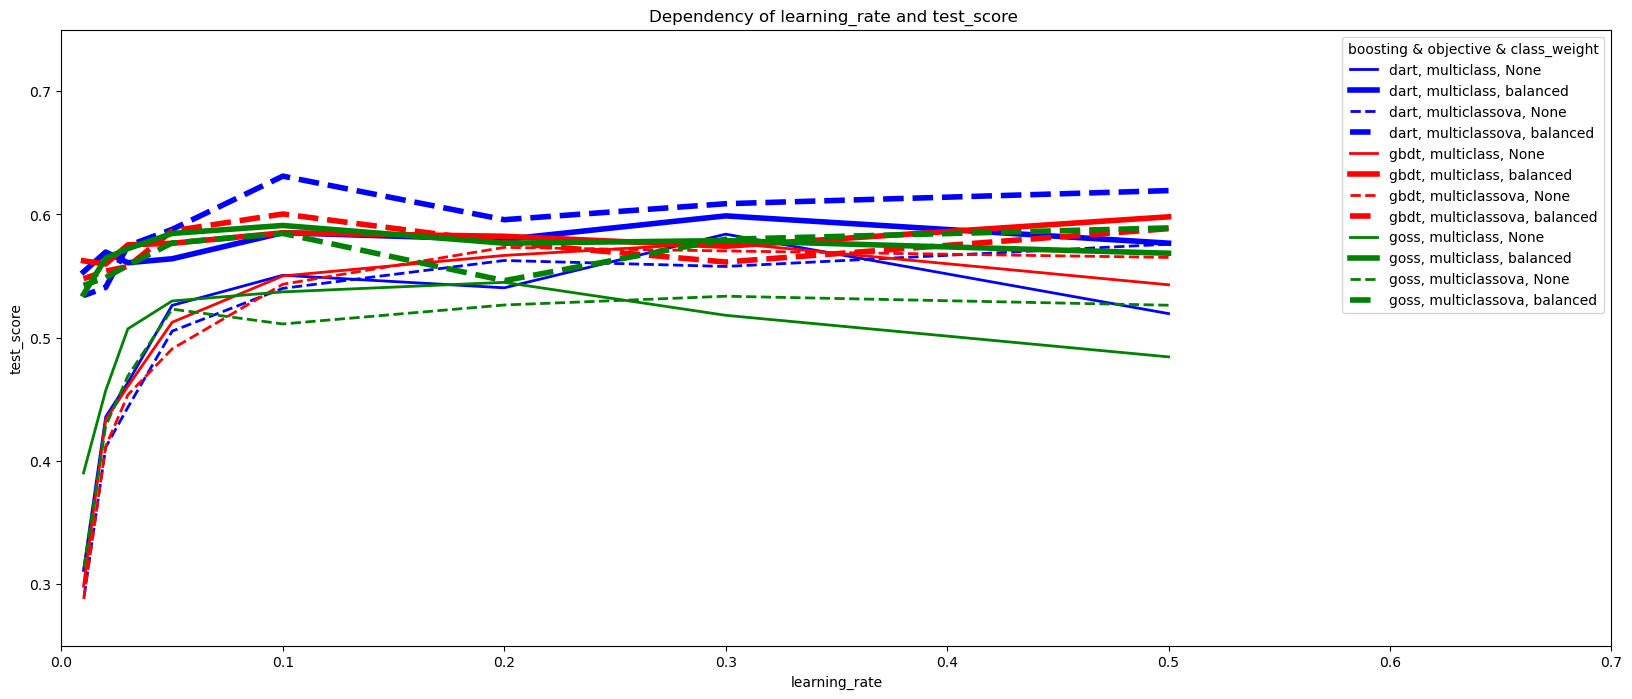

In [13]:
p.draw()

### LGBM Random Forest

В этой модели learning rate не влияет, но влияет размер поднабора 

In [14]:
warnings.filterwarnings('ignore')
estimator = lgb.LGBMClassifier(objective='multiclass',max_features=None)
param_grid = {
    'boosting' :['rf'],
    'subsample':[.5,.6,.7,.8,.9,.95],
    'subsample_freq':[1,2,4],
    'n_estimators': [8],
    'max_depth':  [16],
    'num_leaves': [199],
    'class_weight': ['balanced',None],
    'objective':['multiclass','multiclassova']
}
cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
gs_rf = GridSearchCV(estimator, param_grid, cv=4,scoring= 'f1_weighted')
gs_rf.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y)],callbacks=cbf)
gs_rf.cv_results_     
gs_rf.best_params_

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.992832
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.981068
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.977855
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.977855
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.977855
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: bo

Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.82417
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.82417
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.82417
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.82417
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.82417
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	val

Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.766186
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.757009
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.753679
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.753679
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.753679
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7

Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8

[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.687118
[LightGBM] [Warning] boosting is set=rf, boosting_

Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.67728
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.67728
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.67728
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.67728
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.67728
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[7]	val

Did not meet early stopping. Best iteration is:
[5]	valid_0's multi_logloss: 0.599159
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[5]	valid_0's multi_logloss: 0.599159
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[5]	valid_0's multi_logloss: 0.599159
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[5]	valid_0's multi_logloss: 0.599159


{'boosting': 'rf',
 'class_weight': None,
 'max_depth': 16,
 'n_estimators': 8,
 'num_leaves': 199,
 'objective': 'multiclass',
 'subsample': 0.6,
 'subsample_freq': 2}

In [15]:
p_rf = ResultPlot(x='subsample',through =['objective','class_weight','subsample_freq'],params= { 
    'features':  ['subsample','subsample_freq','class_weight','objective'],
    'limits': {'subsample': (.4, 1), 'test_score': (0.4, 0.7)}, 
    'title': 'Dependency of learning_rate and test_score ',
    'figsize': (20, 8)
    } )
p_rf.add_result(gs_rf.cv_results_,'random_forest')
p_rf.rf.sort_values(by='test_score',ascending=False).head(20)

,subsample,subsample_freq,class_weight,objective,test_score,label
40,0.6,2,None,multiclass,0.610269,random_forest
39,0.6,1,None,multiclass,0.607774,random_forest
12,0.9,1,balanced,multiclass,0.600588,random_forest
57,0.6,1,None,multiclassova,0.600540,random_forest
58,0.6,2,None,multiclassova,0.599456,random_forest
45,0.8,1,None,multiclass,0.590604,random_forest
30,0.9,1,balanced,multiclassova,0.586221,random_forest
48,0.9,1,None,multiclass,0.586172,random_forest
42,0.7,1,None,multiclass,0.584711,random_forest
63,0.8,1,None,multiclassova,0.584004,random_forest


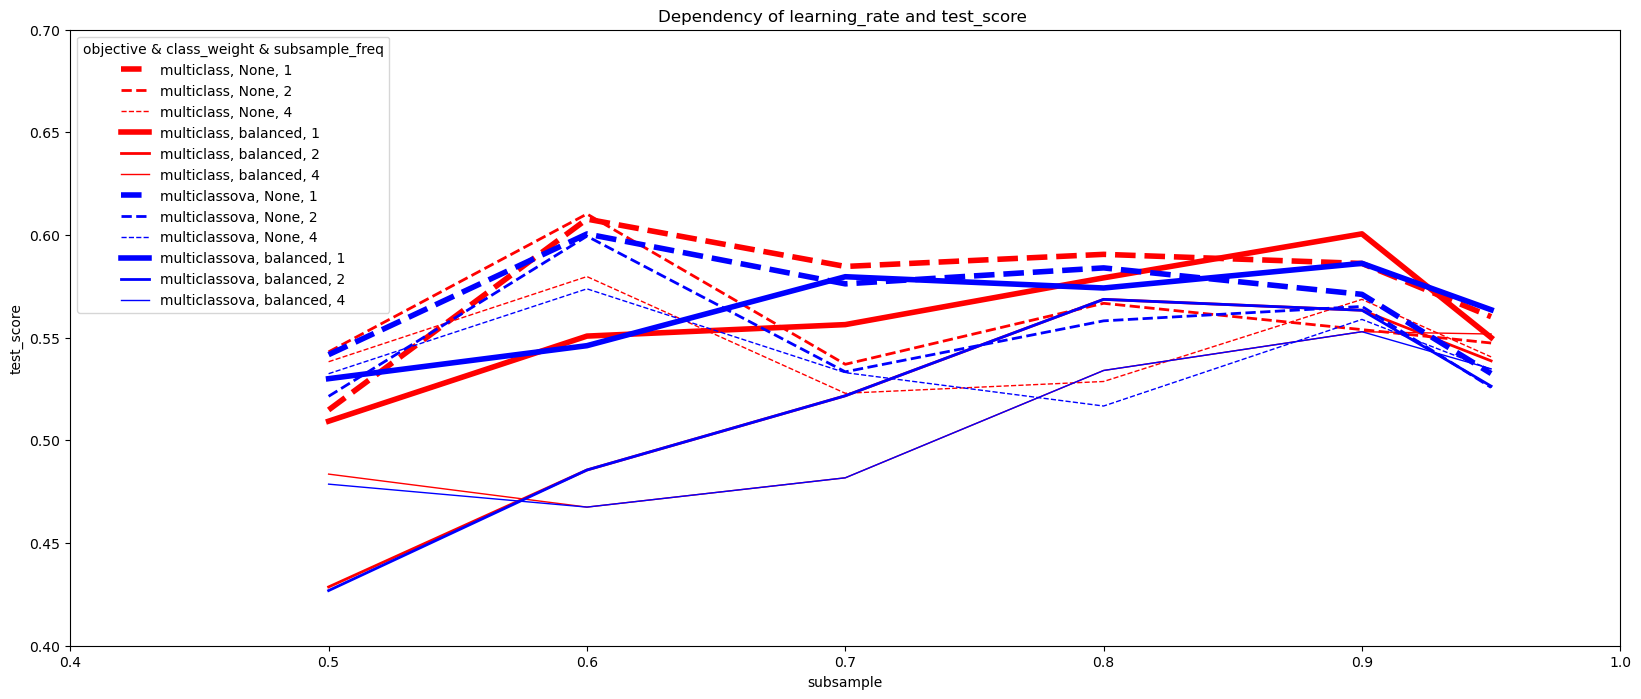

In [16]:
p_rf.draw()

Похоже результат нестабилен.  
В любом случае он остается ниже 0.6 и эта модель проигрывет градиентным 

### Классический RandomForest

In [17]:
warnings.filterwarnings('ignore')
estimator = RandomForestClassifier()
param_grid = {
    'n_estimators': [8,16,32,64,128,256],
    'max_depth':  [8],
    'class_weight': ['balanced',None],
    'max_features': ['sqrt','log2',None],
    'criterion':['gini', 'entropy', 'log_loss']
}
cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
gs_rf1 = GridSearchCV(estimator, param_grid, cv=4,scoring= 'f1_weighted')
gs_rf1.fit(tr_X, tr_y)
gs_rf1.cv_results_     
gs_rf1.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 8}

In [18]:
p_rf1 = ResultPlot(x='n_estimators',through =['max_features','criterion','class_weight'],params= { 
    'features':  ['n_estimators','class_weight','criterion','max_features'],
    'limits': {'n_estimators': (8, 350), 'test_score': (0.4, 0.7)}, 
    'title': 'Dependency of learning_rate and test_score ',
    'figsize': (20, 10)
    } )
p_rf1.add_result(gs_rf1.cv_results_,'random_forest')
p_rf1.rf.sort_values(by='test_score',ascending=False).head(20)

,n_estimators,class_weight,criterion,max_features,test_score,label
78,8,None,entropy,log2,0.600236,random_forest
10,128,balanced,gini,log2,0.599744,random_forest
37,16,balanced,log_loss,sqrt,0.599000,random_forest
82,128,None,entropy,log2,0.591437,random_forest
24,8,balanced,entropy,log2,0.589435,random_forest
4,128,balanced,gini,sqrt,0.583465,random_forest
19,16,balanced,entropy,sqrt,0.583410,random_forest
29,256,balanced,entropy,log2,0.583283,random_forest
30,8,balanced,entropy,None,0.582998,random_forest
61,16,None,gini,log2,0.582741,random_forest


* все результаты ниже 0.60
* ограничение признаков полезно, лучший гиперпарамет здесь - log2(синий), затем - sqrt
* сбалансированнй алгоритм(толстый) - лучше несбалансированного
* по функции потерь трудно что-то сказать

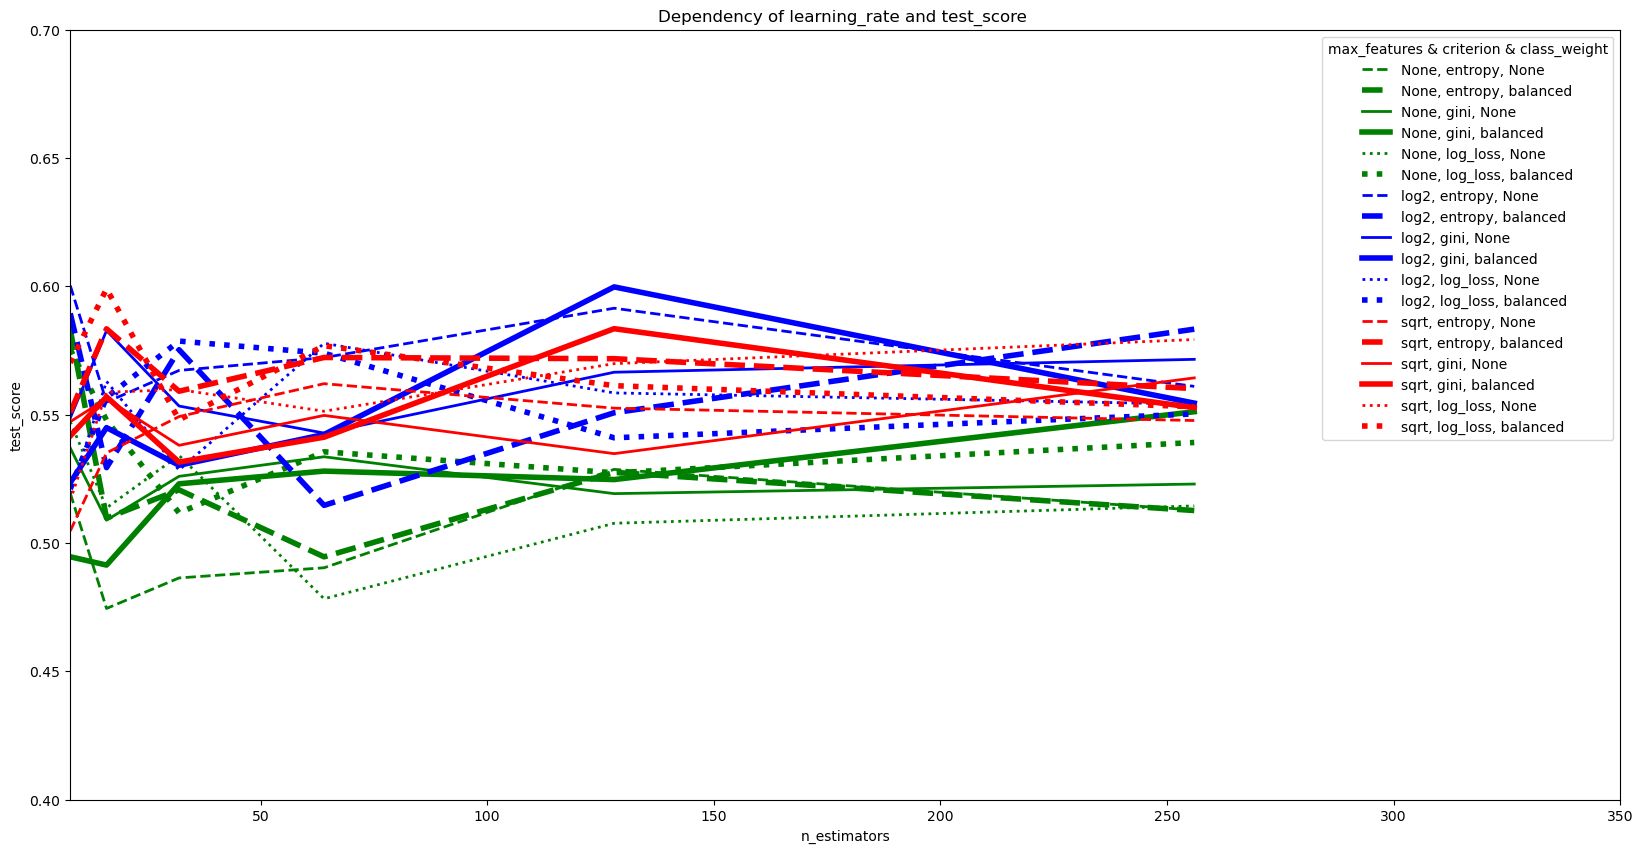

In [19]:
p_rf1.draw()

Протестируем ещё эту модель с большим числом деревьев и различной глубиной, но с оптимальными class_weight и max_features 

In [20]:
%%time
warnings.filterwarnings('ignore')
estimator = RandomForestClassifier()
param_grid = {    'n_estimators': [8,16,32,64,128,256],
    'max_depth':  [8,16,32,64],
    'class_weight': ['balanced'], #,None],
    'max_features': ['log2'], #,None],
    'criterion':['gini', 'entropy', 'log_loss']
}
cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
gs_rf2 = GridSearchCV(estimator, param_grid, cv=4,scoring= 'f1_weighted')
gs_rf2.fit(tr_X, tr_y)
gs_rf2.cv_results_     
gs_rf2.best_params_

CPU times: total: 1min 4s
Wall time: 1min 6s


{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': 'log2',
 'n_estimators': 64}

In [21]:
p_rf2 = ResultPlot(x='n_estimators',through =['max_depth','criterion'],params= { 
    'features':  ['n_estimators','max_depth','criterion'],
    'limits': {'n_estimators': (8, 300), 'test_score': (0.4, 0.7)}, 
    'title': 'Dependency of learning_rate and test_score ',
    'figsize': (20, 10)
    } )
p_rf2.add_result(gs_rf2.cv_results_,'random_forest')
p_rf2.rf.sort_values(by='test_score',ascending=False).head(20)

,n_estimators,max_depth,criterion,test_score,label
9,64,16,gini,0.601952,random_forest
57,64,16,log_loss,0.600880,random_forest
59,256,16,log_loss,0.598738,random_forest
42,8,64,entropy,0.595597,random_forest
39,64,32,entropy,0.591560,random_forest
34,128,16,entropy,0.590187,random_forest
26,32,8,entropy,0.586971,random_forest
46,128,64,entropy,0.585077,random_forest
16,128,32,gini,0.583921,random_forest
18,8,64,gini,0.583835,random_forest


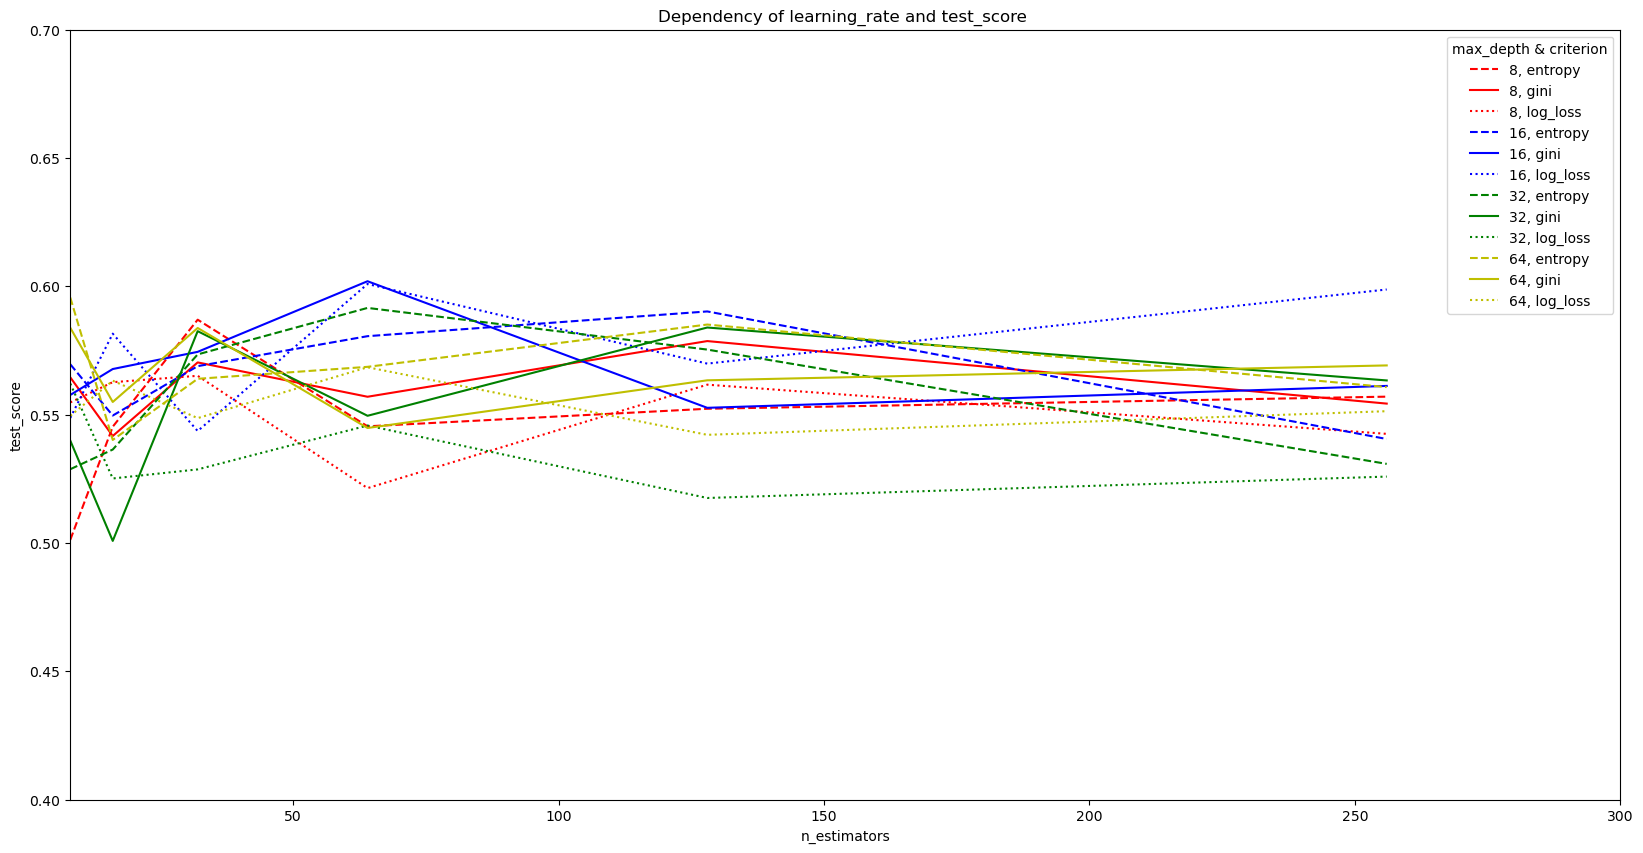

In [22]:
p_rf2.draw()

Создаётся впечатление, что с ростом числа деревьев графики сходятся к одному значению, а максимум .61 может быть случайным выбросом  
Однозначного влияния глубины дерева на результат не заметно

## Финальный тест

Для финального теста выбран набор гиперпараметров с лучшим результатом при кроссвалидации  
во всяком случае не вижу причин для другого выбора

In [23]:
final_params = gs.best_params_.copy()
final_model = lgb.LGBMClassifier(**final_params)
print("Параметры финального теста:",final_model.get_params(),"\n")
final_model.fit(tr_X,tr_y)
pr = final_model.predict(te_X)
out = ''
for metric in [f1_score,recall_score,precision_score]:#,accuracy_score]:
    out += f"{metric.__name__}:{round(metric(te_y,pr,average='weighted'),3)} \t"
print(out+f"\taccuracy {accuracy_score(te_y,pr)}")

Параметры финального теста: {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 16, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 32, 'n_jobs': -1, 'num_leaves': 199, 'objective': 'multiclassova', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'boosting': 'dart'} 

f1_score:0.517 	recall_score:0.527 	precision_score:0.541 		accuracy 0.5272727272727272


Визуально оценим связь между вероятностной оценкой уровней моделью , предсказанием и реальными значениями  

In [24]:
pb = pd.DataFrame( final_model.predict_proba(te_X),index= te_y.index,columns= final_model.classes_ )
pr = pd.Series( final_model.predict(te_X),index= te_y.index,name='pr' )
pb.join(pr).join(te_y)      

,A2,B1,B2,C1,pr,level
110,0.035580,0.035575,0.853884,0.605013,B2,B2
12,0.190018,0.698648,0.038972,0.025438,B1,B1
1,0.384585,0.237115,0.050362,0.041485,A2,A2
20,0.295355,0.679418,0.096524,0.036735,B1,B1
178,0.086002,0.266572,0.571398,0.064736,B2,B2
16,0.120543,0.845984,0.048664,0.050082,B1,B1
114,0.022972,0.029200,0.068281,0.302681,C1,B2
142,0.025899,0.036992,0.344501,0.072963,B2,C1
129,0.566808,0.458333,0.057699,0.046654,A2,B2
206,0.149659,0.304512,0.452554,0.048241,B2,B1


Модель часто промахивается уже на определении вероятности, например
0.784047 	0.131047 	0.122902 	0.023233 	A2 	B2
Насколько я понимаю, это нельзя исправить настройками модели, скорее проблема в подготовке данных и нужно поискать какие-либо признаки, которые дадут дополнительную информацию .  
Возможно также , что уровень некоторых фильмов определен с потолка и при небольшом количестве фильмов они влияют на результат.

Вообще , объём бызы мне кажется очень маленьким и увеличение количества оценённых фильмов может дать ответ на некоторые вопросы..

### Оценка влияния признаков

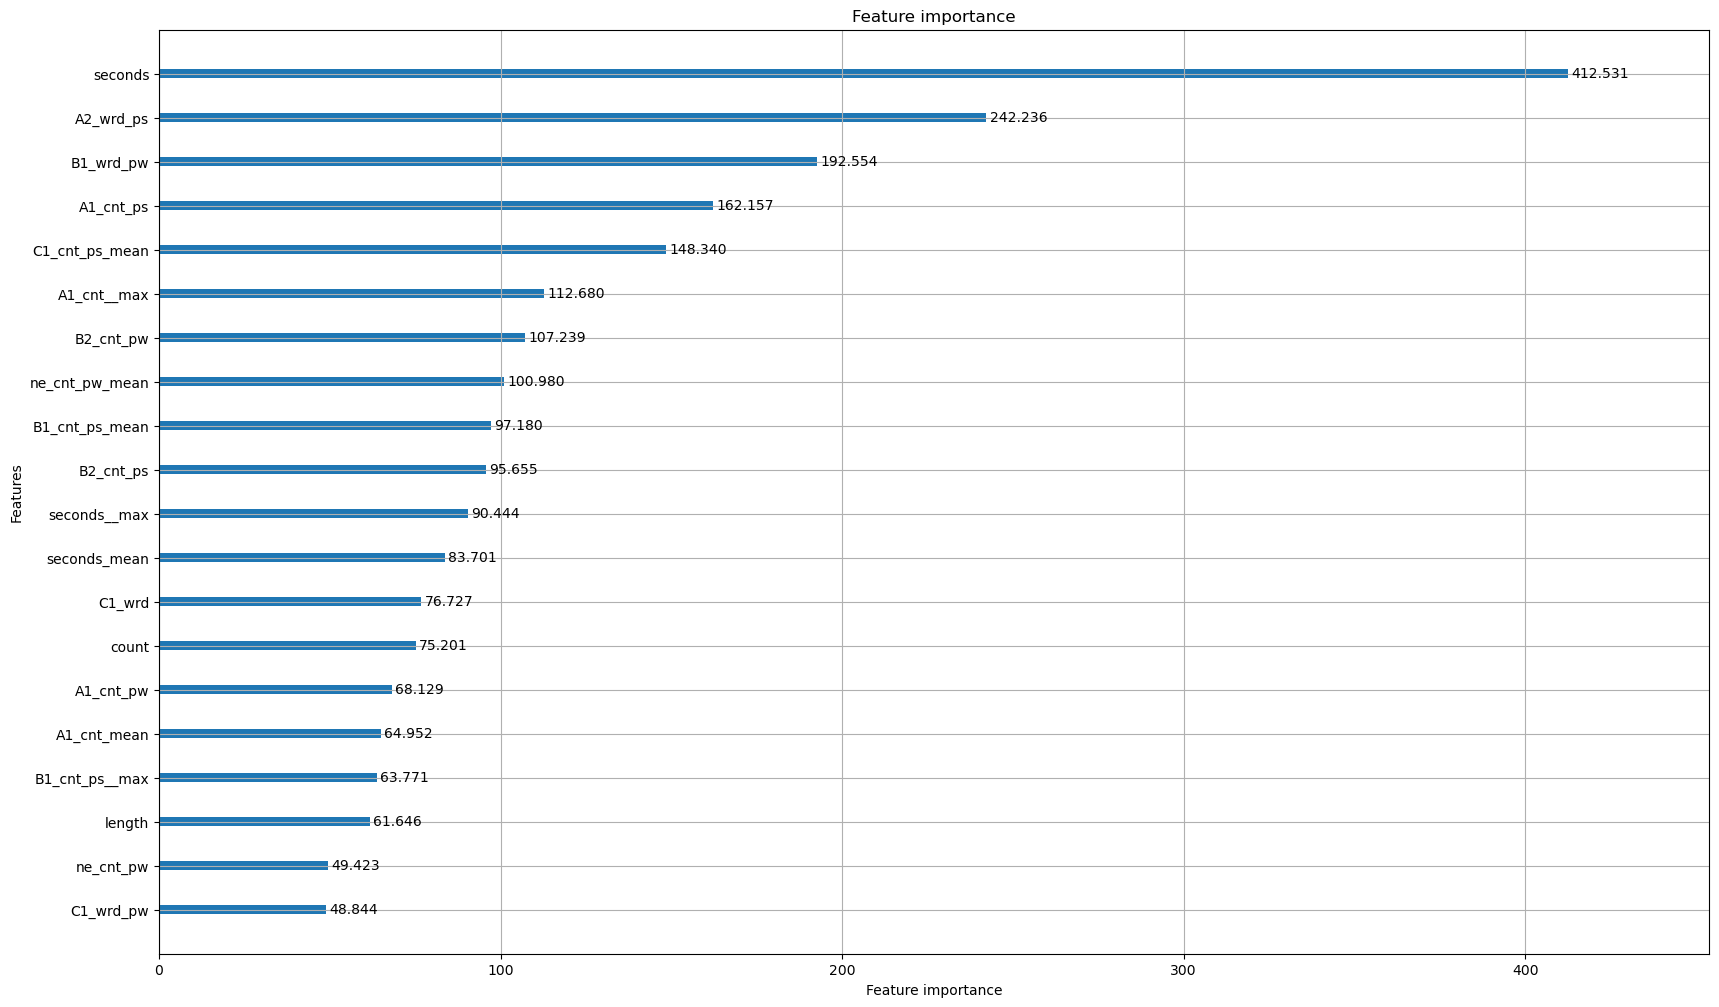

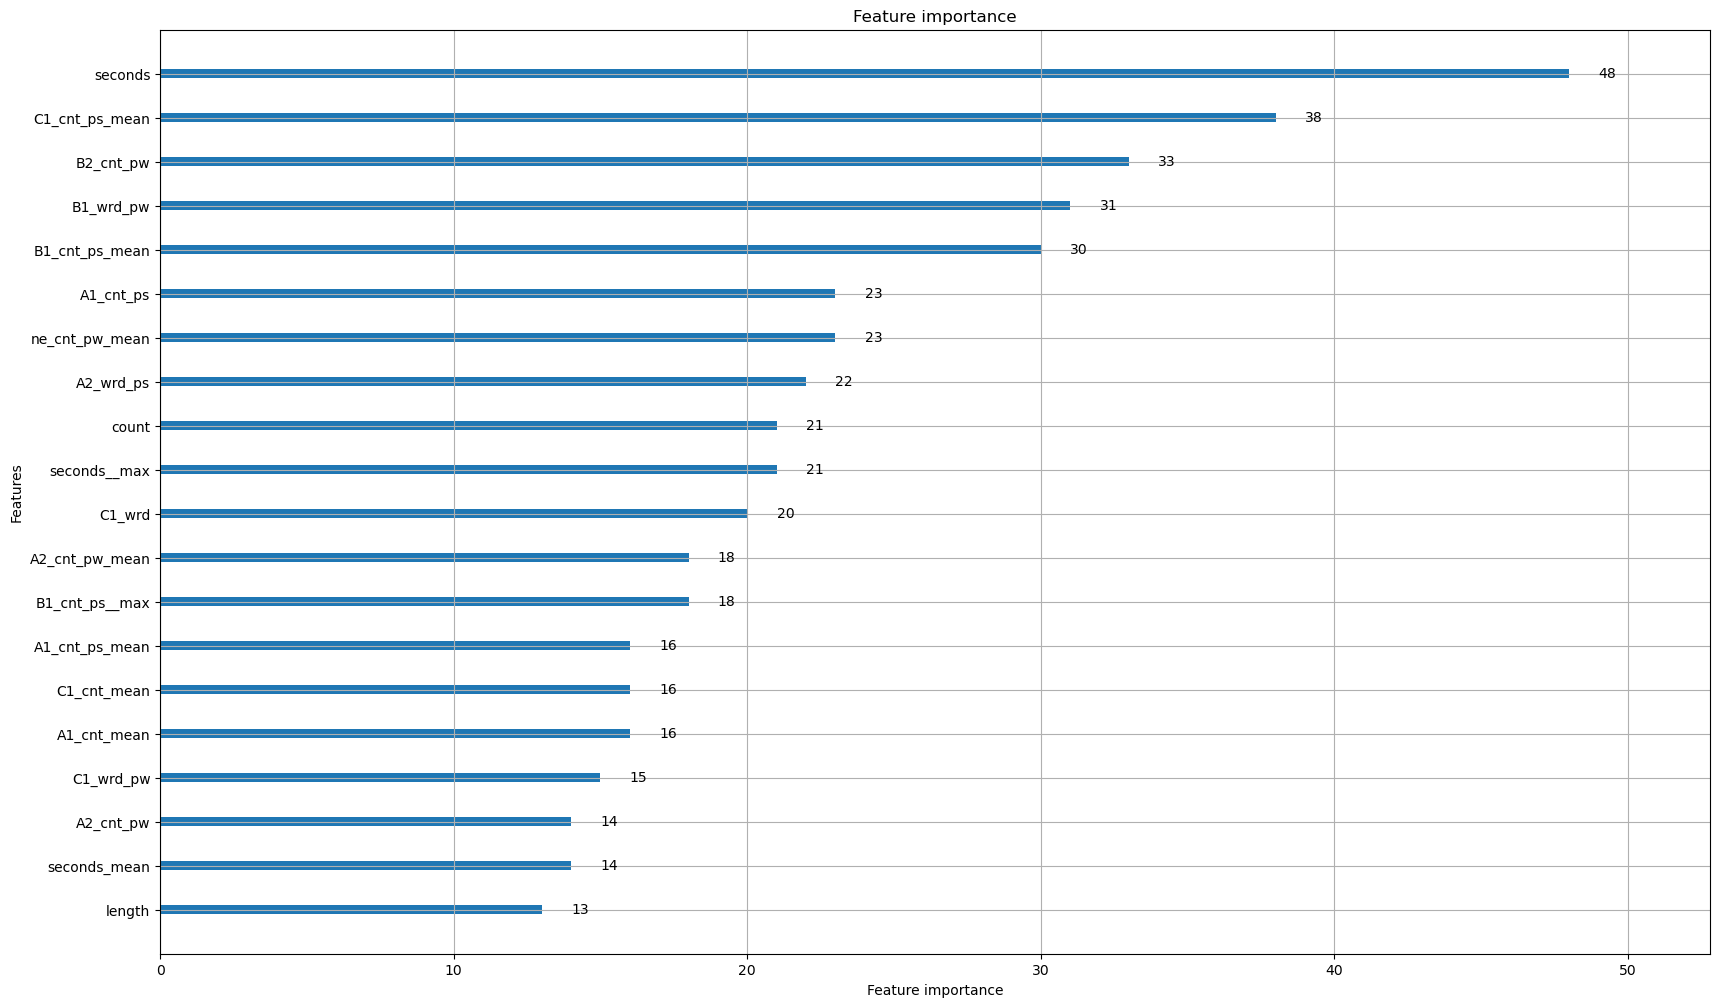

In [25]:
lgb.plot_importance(final_model,importance_type='gain',max_num_features=20,figsize=(20,12) );
lgb.plot_importance(final_model,importance_type='auto',max_num_features=20,figsize=(20,12) );

* Больше всего влияет время фильма
* Дальше идёт серия признаков  с суффиксом _ps_ показывающя плотность слов на единицу времени(темп речи)
* Почему-то незаметно влияния отдельных категорий

### Оценка финального теста

Большая разница метрики с результатами  кроссвалидации требует объяснения, сравним с результатами на датсетах другого размера. Проведем финальный тест на разбиении сокращенного набора данных (с теми же размерами, что были в кроссвалидации ) и кроссвалидацию на  полном наборе данных, соответствующем финальному тесту

#### Тест с лучшими гиперпараметрами на сокращенном наборе

In [26]:
df_X_short  = tr_X.copy()
df_y_short  = tr_y.copy()
tr_X_short,te_X_short,tr_y_short,te_y_short= train_test_split(df_X_short,df_y_short,test_size = 0.25,shuffle=True)

In [27]:
short_model = lgb.LGBMClassifier(**final_params)

In [28]:
print("Параметры теста на сокращенном датасете:",short_model.get_params(),"\n")
final_model.fit(tr_X_short,tr_y_short)
pr_short = final_model.predict(te_X_short)
out = ''
for metric in [f1_score,recall_score,precision_score]:#,accuracy_score]:
    out += f"{metric.__name__}:{round(metric(te_y_short,pr_short,average='weighted'),3)} \t"
print(out+f"\taccuracy {accuracy_score(te_y_short,pr_short)}")

Параметры теста на сокращенном датасете: {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 16, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 32, 'n_jobs': -1, 'num_leaves': 199, 'objective': 'multiclassova', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'boosting': 'dart'} 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
f1_score:0.563 	recall_score:0.561 	precision_score:0.607 		accuracy 0.5609756097560976


Полученный результат (0.56)  ближе к результатам кроссвалидации c теми же гиперпараметрами  на сокращенном наборе (0.63) 

#### Кроссвалидация на полном наборе 

Выполним код ячеек 10-12 для полного набора данных

In [29]:
warnings.filterwarnings('ignore')
estimator = lgb.LGBMClassifier(objective='multiclass',max_features=None)
param_grid = {
    'boosting' :['gbdt','dart','goss'],
    'learning_rate': [.5,.3,.2,.1,.05,.03,.02,.01],
    'n_estimators': [32],
    'max_depth':  [16],
    'num_leaves': [199],
    'class_weight': ['balanced',None],
    'objective':['multiclass','multiclassova']
}
cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
gs_long = GridSearchCV(estimator, param_grid, cv=4,scoring= 'f1_weighted')
gs_long.fit(df[X], df[y], eval_set=(df[X], df[y]),callbacks=cbf)
gs_long.cv_results_     

p_long = ResultPlot(x='learning_rate' ,through =['boosting','objective','class_weight'],params= { 
    'features':  ['learning_rate','boosting','class_weight','objective'],
    'limits': {'learning_rate': (0, .7), 'test_score': (0.25, 0.75)}, 
    'title': 'Dependency of learning_rate and test_score ',
    'figsize': (20, 8)
    } )
p_long.add_result(gs_long.cv_results_,'gradient boosting')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 0.381865
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 0.38159
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 0.38159
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 0.38159
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 0.38159
[LightGBM] [Warning] boosting is s

Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.369352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.369352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.369352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.369352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.369352
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.369352
[LightGBM] [Warn

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current val

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current val

Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.318714
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warn

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current val

Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warn

Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148
[LightGBM] [Warn

Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.312148


In [30]:
p_long.rf.sort_values(by='test_score',ascending=False).head(20)

,learning_rate,boosting,class_weight,objective,test_score,label
85,0.20,goss,None,multiclassova,0.455932,gradient boosting
64,0.50,goss,balanced,multiclass,0.448733,gradient boosting
66,0.30,goss,balanced,multiclass,0.447565,gradient boosting
48,0.50,dart,None,multiclass,0.442934,gradient boosting
36,0.20,dart,balanced,multiclass,0.440863,gradient boosting
33,0.50,dart,balanced,multiclassova,0.440469,gradient boosting
21,0.20,gbdt,None,multiclassova,0.436682,gradient boosting
1,0.50,gbdt,balanced,multiclassova,0.435439,gradient boosting
4,0.20,gbdt,balanced,multiclass,0.433388,gradient boosting
22,0.10,gbdt,None,multiclass,0.431634,gradient boosting


Метрика резко упала и даже хуже, чем в оригинальном тесте. Это даже нельзя объяснить тем ,что в основной ветке были спрятаны какие-то особо неудачные данные, так как при новом разбиении применён решаффлинг, скорее я предполагаю зависимость от размера набора 

## Выводы

* В текущей версии сборщик данных и модель способны предсказывать категорию фильма по субититрам с вероятностью ~0.5
* Существует большой разрыв между результатом кроссвалидации и финальным тестом, возможная причина - неустойчивость модели к алгоритму и размеру обучающей/тестирующей выборки
* Основная идея для кардинального улучшения  результата - увеличить объём обучающей выборки